# Weight Decay

In [3]:
pip install banner

Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

import banner

topics = ['Linear model with two correlated distractors',
          'Gradient descent to fit linear model',
          'Add weight penalty to gradient',
          'Using Generative AI to produce our code']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear model with two correlated distractors.

If two input variables are very correlated, positively or negatively, and they have high-magnitude weights, they may have very little effect on the output of the model.  The sum of the products of their weights and values can be close to zero,

The magnitude of weights in a model is often used to indicate the relative importance of input variables, but in this case this would be very misleading.

Let's see this with some example data.  Let's train a linear model to approximate

$$f(x_{i,1}) = 1 + 3 x_{i, 1}$$

for sample $i$, but include two additional variables in each sample, $x_{i, 2}$ and $x_{i, 3}$ that do not affect the value of $f(x_{i, 1})$ and that are highly correlated. In math-eze:

$$f(x_{i,1}) = 1 + 3 x_{i,1} + 0 x_{i,2} + 0 x_{i, 3}$$

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
X1 = np.random.uniform(-10, 10, (100, 1))
X2 = np.random.uniform(-10, 10, (100, 1))
X3 =  X2
X = np.hstack((X1, X2, X3))

T = 1 + 3 * X1

X.shape, T.shape

((100, 3), (100, 1))

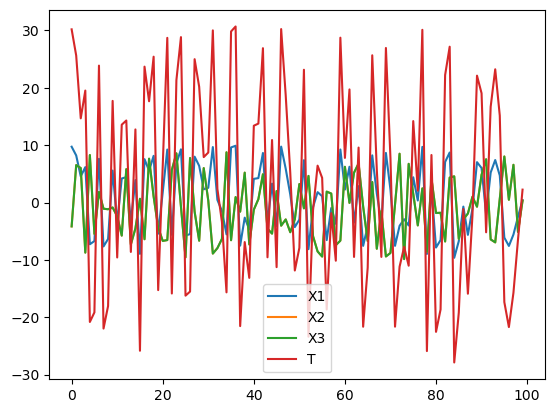

In [9]:
plt.plot(X)
plt.plot(T)
plt.legend(('X1', 'X2', 'X3', 'T'));

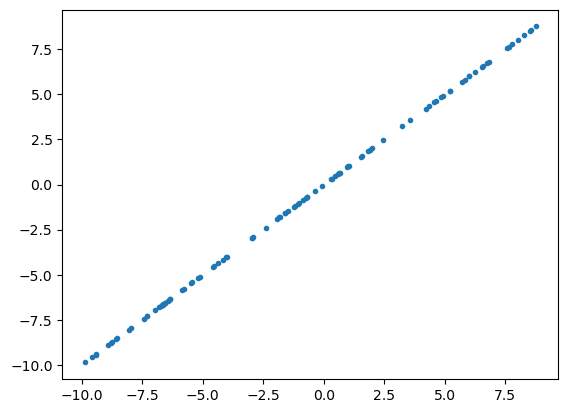

In [11]:
plt.plot(X2, X3, '.')

# Gradient descent to fit linear model

In [13]:
def model(X, W):
    return W[0, :] + X @ W[1:, :]

def dYdW(X):
    # One row per sample in X, T.  One column per W component.
    # For first one, is constant 1.
    # For second one, is value of X
    return np.insert(X, 0, 1, axis=1)

#Gradient of E with respect to Y
def dEdY(Y, T):
    return -2 * (T - Y)
    
# Gradient of E with respect to W.
def dEdW(X, T, Y):
    result = dEdY(Y, T).T @ dYdW(X) / X.shape[0]
    return result.T
    

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

def gradient_descent(model_f, gradient_f, rmse_f, X, T, W, rho, n_steps):
    error_sequence = []
    W_sequence = []
    for step in range(n_steps):
        Y = model_f(X, W)
        W -= rho * gradient_f(X, T, Y) 
        
        error_sequence.append(rmse_f(Y, T))
        W_sequence.append(W.flatten())
        
    return W, error_sequence, W_sequence

In [15]:
X.shape

(100, 3)

In [19]:
# W has four values, one for the bias (constant 1) input, and three for the three input variables
W = np.random.uniform(-10, 10, (4, 1))
W.shape

(4, 1)

In [21]:
n_steps = 10000
rho = 0.001

W, error_sequence, W_sequence = gradient_descent(model, dEdW, rmse, X, T, W, rho, n_steps)
print(f'Gradient Descent:  Error is {rmse(model(X, W), T):.2f}   W is \n{W}')

Gradient Descent:  Error is 0.00   W is 
[[ 0.99999996]
 [ 3.        ]
 [ 3.07593423]
 [-3.07593423]]


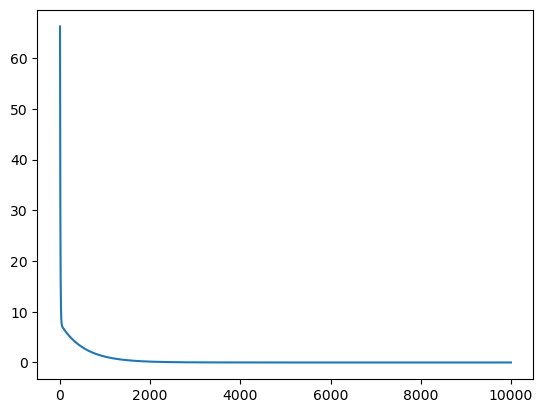

In [23]:
plt.plot(error_sequence);

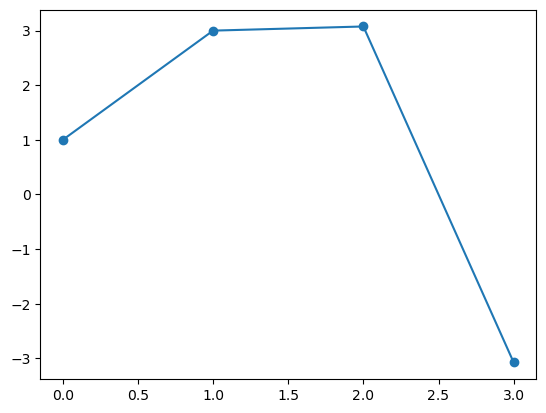

In [25]:
plt.plot(W, '-o');

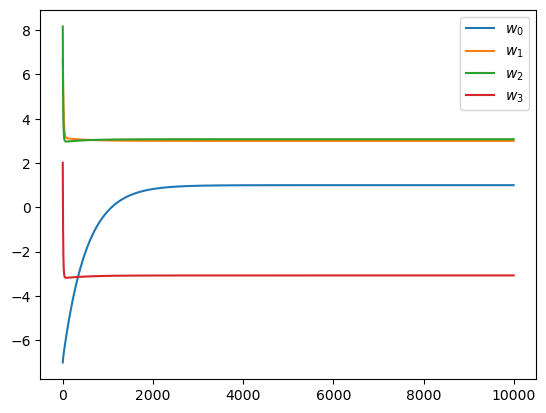

In [27]:
plt.plot(W_sequence)
plt.legend(('$w_0$', '$w_1$', '$w_2$', '$w_3$'));

# Add weight penalty to gradient

In [29]:
def gradient_descent(model_f, gradient_f, rmse_f, X, T, W, rho, rho_decay, n_steps):
    error_sequence = []
    W_sequence = []
    for step in range(n_steps):

        Y = model_f(X, W)
        # if positive, we add a little bit to weight. if negative, we substract a little.
        W -= rho * (gradient_f(X, T, Y)  + rho_decay * W)
        
        error_sequence.append(rmse_f(Y, T))
        W_sequence.append(W.flatten())
        
    return W, error_sequence, W_sequence

In [31]:
# W has four values, one for the bias (constant 1) input, and three for the three input variables
W = np.random.uniform(-10, 10, (4, 1))

n_steps = 10000
rho = 0.001
rho_decay = 0.2

W, error_sequence, W_sequence = gradient_descent(model, dEdW, rmse, X, T, W, rho, rho_decay, n_steps)
print(f'Gradient Descent:  Error is {rmse(model(X, W), T):.2f}   W is \n{W}')

Gradient Descent:  Error is 0.10   W is 
[[ 0.90995341]
 [ 2.99301286]
 [-0.14195257]
 [ 0.13791117]]


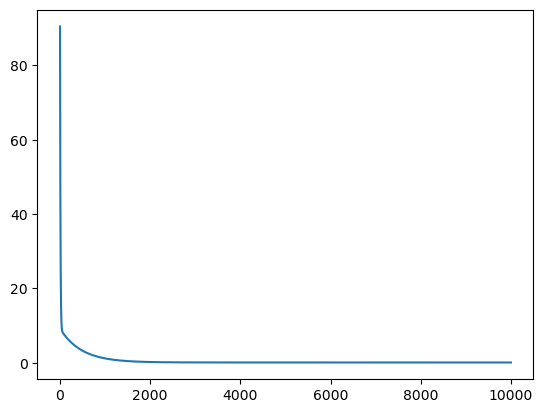

In [33]:
plt.plot(error_sequence);

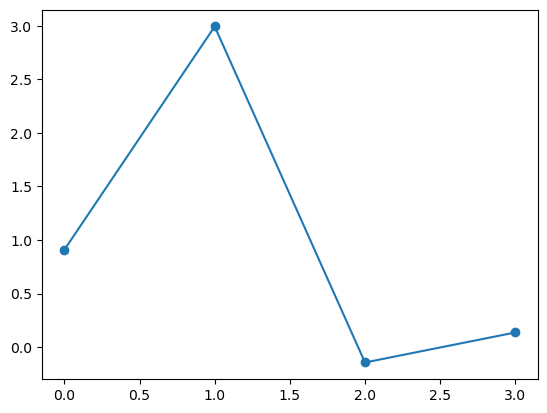

In [39]:
plt.plot(W, '-o');

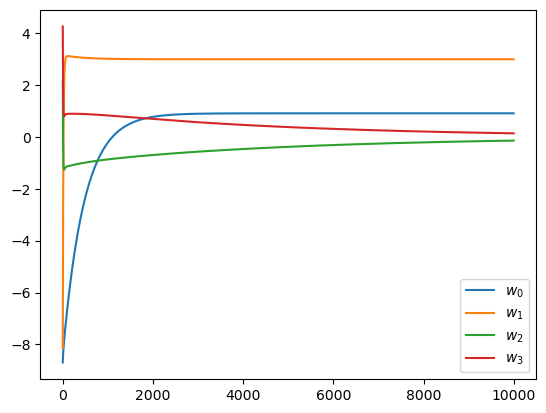

In [41]:
plt.plot(W_sequence)
plt.legend(('$w_0$', '$w_1$', '$w_2$', '$w_3$'));

# Using Generative AI to produce our code

Claude was used for this example.

Here is what I get with the prompt

> Implement adamw in numpy without using pytorch

In [45]:
import numpy as np

def adamw(weights, gradients, lr, weight_decay, beta1=0.9, beta2=0.999, epsilon=1e-8):

    t = 0 # timestep
    m = np.zeros(weights.shape) # 1st moment
    v = np.zeros(weights.shape) # 2nd moment

    while True:
        t += 1
        lr_t = lr * np.sqrt(1 - beta2**t) / (1 - beta1**t) # lr decay

        m = beta1 * m + (1 - beta1) * gradients 
        v = beta2 * v + (1 - beta2) * (gradients**2)

        weight_decay_term = weight_decay * weights
        m_hat = m / (1 - beta1**t) 
        v_hat = v / (1 - beta2**t)

        weights -= lr_t * (m_hat + weight_decay_term) / (np.sqrt(v_hat) + epsilon)

        # Return weights for update
        yield weights
        
    weights = np.array([1.0, 2.0])
    
    opt = adamw(weights, gradients, lr=0.001, weight_decay=0.1)
    for w in opt:
        # Update weights each step
        weights = w

With this follow on prompt:

> how is this different from adam

I see

<blockquote>
    The main difference between the Adam and AdamW optimizers is that AdamW includes a weight decay regularization term while Adam does not.

The key differences in the implementations are:

Adam:

Does not include a weight decay term in the update rule
The update rule is: weights = weights - lr * m_hat / (sqrt(v_hat) + epsilon)
AdamW:

Includes a weight decay term multiplied by the weights in the update rule
The update rule is: weights = weights - lr * (m_hat + weight_decay*weights) / (sqrt(v_hat) + epsilon)
So AdamW has the additional weight_decay*weights term added to the update rule.

Weight decay helps reduce overfitting by penalizing large weights and acts as a regularization method. This tends to improve generalization performance.

The weight decay term ends up shrinking the weights values over time, similar to L2 regularization.

So in summary:

Adam only uses the gradients to adapt the learning rate and update the weights
AdamW uses the gradients but also decays the weights directly each step via the weight decay term
AdamW provides the regularization benefits of weight decay which often improves results
That's the main difference - AdamW incorporates weight decay regularization into the optimization process.
    </blockquote>

This is somewhat misleading.  The article [Why AdamW matters](https://towardsdatascience.com/why-adamw-matters-736223f31b5d) by Fabio M. Graetz explains why a slightly different implentation of AdamW is better, using this algorithm specification:

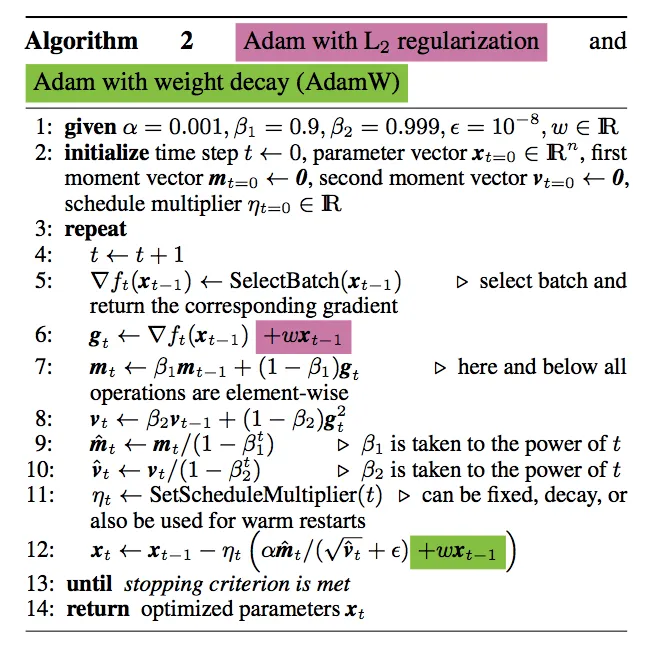

from [*Fixing Weight Decay Regularization in Adam*](https://arxiv.org/pdf/1711.05101v2.pdf), ICLR 2018, by I. Loshchilov and F. Hutter.

The Graetz article also cites [*Decoupled Weight Decay Regularization*](https://arxiv.org/abs/1711.05101), ICLR 2019, by Loshchilov and Hutter, that demonstrates the importance of correctly placing the weight decay term for AdamW.